## 1. Import package

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from collections import Counter
import tensorflow as tf

import os
import pickle
import re
from tensorflow.python.ops import math_ops
import tensorflow as tf
import datetime
from tensorflow import keras
from tensorflow.python.ops import summary_ops_v2
import time
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt


## 2.Unzip the dataset

In [3]:
!unzip ml-1m.zip

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


## 3.View movies.dat and users.dat and ratings.dat

load users.dat " UserID::Gender::Age::Occupation::Zip-code " 

In [4]:
users_name = ['UserID', 'Gender', 'Age', 'OccupationID', 'Zip-code']
users = pd.read_csv('./ml-1m/users.dat', sep='::', header = None, names = users_name, engine = 'python',encoding = "ISO-8859-1")
users.head(5)

,UserID,Gender,Age,OccupationID,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [5]:
users.describe()

,UserID,Age,OccupationID
count,6040.000000,6040.000000,6040.000000
mean,3020.500000,30.639238,8.146854
std,1743.742145,12.895962,6.329511
min,1.000000,1.000000,0.000000
25%,1510.750000,25.000000,3.000000
50%,3020.500000,25.000000,7.000000
75%,4530.250000,35.000000,14.000000
max,6040.000000,56.000000,20.000000


load movies.dat

In [6]:
movies_name = ['MovieID', 'Title', 'Genres']
movies = pd.read_csv('./ml-1m/movies.dat', sep='::', header = None, names = movies_name, engine = 'python',encoding = "ISO-8859-1")
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


load ratings.dat

In [7]:
ratings_name = ['UserID','MovieID', 'Rating', 'timestamps']
ratings = pd.read_csv('./ml-1m/ratings.dat', sep='::', header = None, names = ratings_name, engine = 'python',encoding = "ISO-8859-1")
ratings.head()

,UserID,MovieID,Rating,timestamps
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


## 4.Data pre-processing

### 4.1 Data pre-processing of users.dat、movies.dat and ratings.csv

In [8]:
def read_dat():
    """
    Load Dataset from File
    """
    
    users_name = ['UserID', 'Gender', 'Age', 'JobID', 'Zip-code']
    users = pd.read_table('./ml-1m/users.dat', sep='::', header = None, names = users_name, engine = 'python',encoding = "ISO-8859-1")
    
    users = users.filter(regex='UserID|Gender|Age|JobID')
    users_orga = users.values
    
    gender_map = {'F':0, 'M':1}
    users['Gender'] = users['Gender'].map(gender_map)

    age_map = {val:ii for ii,val in enumerate(set(users['Age']))}
    users['Age'] = users['Age'].map(age_map)

    
    movies_name = ['MovieID', 'Title', 'Genres']
    movies = pd.read_table('./ml-1m/movies.dat', sep='::', header=None, names = movies_name, engine = 'python',encoding = "ISO-8859-1")
    movies_orga = movies.values
    
    pattern = re.compile(r'^(.*)\((\d+)\)$')

    title_change = {val:pattern.match(val).group(1) for ii,val in enumerate(set(movies['Title']))}
    movies['Title'] = movies['Title'].map(title_change)

    
    genres_set = set()
    for val in movies['Genres'].str.split('|'):
        genres_set.update(val)

    genres_set.add('<PAD>')
    
    genres2int = {val:ii for ii, val in enumerate(genres_set)}

    
    genres_change = {val:[genres2int[row] for row in val.split('|')] for ii,val in enumerate(set(movies['Genres']))}

    
    for key in genres_change:
        for cnt in range(max(genres2int.values()) - len(genres_change[key])):
            genres_change[key].insert(len(genres_change[key]) + cnt,genres2int['<PAD>'])
    
    movies['Genres'] = movies['Genres'].map(genres_change)

    
    title_set = set()
    for val in movies['Title'].str.split():
        title_set.update(val)
    
    title_set.add('<PAD>')
    title2int = {val:ii for ii, val in enumerate(title_set)}

    
    title_count = 15
    title_change = {val:[title2int[row] for row in val.split()] for ii,val in enumerate(set(movies['Title']))}
    
    for key in title_change:
        for cnt in range(title_count - len(title_change[key])):
            title_change[key].insert(len(title_change[key]) + cnt,title2int['<PAD>'])
    
    movies['Title'] = movies['Title'].map(title_change)

    
    ratings_name = ['UserID','MovieID', 'ratings', 'timestamps']
    ratings = pd.read_csv('./ml-1m/ratings.dat', sep='::', header=None, names = ratings_name, engine = 'python',encoding = "ISO-8859-1")
    ratings = ratings.filter(regex = 'UserID|MovieID|ratings')

    
    data = pd.merge(pd.merge(ratings, users), movies)
    
    
    target_fields = ['ratings']
    features_pd, targets_pd = data.drop(target_fields, axis=1), data[target_fields]
    
    features = features_pd.values
    targets_values = targets_pd.values
    
    return title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orga, users_orga

### 4.2 View the user, movie and rating files after  the pre-processing

In [10]:
users.head()

,UserID,Gender,Age,JobID
0,1,0,0,10
1,2,1,5,16
2,3,1,6,15
3,4,1,2,7
4,5,1,6,20


In [11]:
movies.head()

,MovieID,Title,Genres
0,1,"[98, 1780, 4565, 4565, 4565, 4565, 4565, 4565,...","[10, 17, 16, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,2,"[4502, 4565, 4565, 4565, 4565, 4565, 4565, 456...","[14, 17, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1..."
2,3,"[2915, 2014, 4808, 4565, 4565, 4565, 4565, 456...","[16, 9, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
3,4,"[3731, 821, 4529, 4565, 4565, 4565, 4565, 4565...","[16, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
4,5,"[3227, 1715, 792, 3443, 3747, 113, 4565, 4565,...","[16, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."


In [12]:
ratings.head()

,UserID,MovieID,ratings
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


### 4.3 Read the pre-processed data

In [13]:
title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orga, users_orga= read_dat()

with open('./pre_process.pkl', 'wb') as kfc:
    pickle.dump((title_count, 
                 title_set, 
                 genres2int, 
                 features, 
                 targets_values, 
                 ratings, 
                 users, 
                 movies, 
                 data, 
                 movies_orga, 
                 users_orga), 
                kfc)

### 5.Building neural networks

### 5.1 Define the required parameters

In [14]:
embed_dim = 32
uid_max = max(features.take(0,1)) + 1 
gender_max = max(features.take(2,1)) + 1 
age_max = max(features.take(3,1)) + 1 
job_max = max(features.take(4,1)) + 1
movie_id_max = max(features.take(1,1)) + 1 
movie_categories_max = max(genres2int.values()) + 1 
movie_title_max = len(title_set) 
combiner = "sum"
sentences_size = title_count 
window_sizes = {2, 3, 4, 5}
filter_num = 8
movieid2idx = {val[0]:i for i, val in enumerate(movies.values)}
batch_size = 256
dropout_keep = 0.5
learning_rate = 0.0001

In [15]:
def obtain_inputs():
    uid = tf.keras.layers.Input(shape=(1,), dtype='int32', name='uid')  
    user_gender = tf.keras.layers.Input(shape=(1,), dtype='int32', name ='user_gender')  
    user_age = tf.keras.layers.Input(shape=(1,), dtype='int32', name='user_age') 
    user_job = tf.keras.layers.Input(shape=(1,), dtype='int32', name='user_job')

    movie_id = tf.keras.layers.Input(shape=(1,), dtype='int32', name='movie_id') 
    movie_categories = tf.keras.layers.Input(shape=(18,), dtype='int32', name='movie_categories') 
    movie_titles = tf.keras.layers.Input(shape=(15,), dtype='int32', name='movie_titles') 
    return uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles

### 5.2 Building neural network models for obtaining user features and movie features

#### 5.2.1 Define the embedding matrix for User

In [16]:
def obtain_user_embedding(uid, user_gender, user_age, user_job):
    uid_embed_layer = tf.keras.layers.Embedding(uid_max, embed_dim, input_length=1, name='uid_embed_layer')(uid)
    gender_embed_layer = tf.keras.layers.Embedding(gender_max, embed_dim // 2, input_length=1, name='gender_embed_layer')(user_gender)
    age_embed_layer = tf.keras.layers.Embedding(age_max, embed_dim // 2, input_length=1, name='age_embed_layer')(user_age)
    job_embed_layer = tf.keras.layers.Embedding(job_max, embed_dim // 2, input_length=1, name='job_embed_layer')(user_job)
    return uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer

#### 5.2.2 Generating User's features

In [17]:
def obtain_user_feature_layer(uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer):
    
    uid_fc_layer = tf.keras.layers.Dense(embed_dim, name="uid_fc_layer", activation='relu')(uid_embed_layer)
    gender_fc_layer = tf.keras.layers.Dense(embed_dim, name="gender_fc_layer", activation='relu')(gender_embed_layer)
    age_fc_layer = tf.keras.layers.Dense(embed_dim, name="age_fc_layer", activation='relu')(age_embed_layer)
    job_fc_layer = tf.keras.layers.Dense(embed_dim, name="job_fc_layer", activation='relu')(job_embed_layer)

    user_combine_layer = tf.keras.layers.concatenate([uid_fc_layer, gender_fc_layer, age_fc_layer, job_fc_layer], 2)  
    user_combine_layer = tf.keras.layers.Dense(200, activation='tanh')(user_combine_layer)  

    user_combine_layer_flat = tf.keras.layers.Reshape([200], name="user_combine_layer_flat")(user_combine_layer)
    return user_combine_layer, user_combine_layer_flat

#### 5.2.3 Define the embedding matrix for Movie ID

In [18]:
def obtain_movie_id_embed_layer(movie_id):
    movie_id_embed_layer = tf.keras.layers.Embedding(movie_id_max, embed_dim, input_length=1, name='movie_id_embed_layer')(movie_id)
    return movie_id_embed_layer

#### 5.2.4 Merging multiple embedding vectors of movie type

In [19]:
def obtain_movie_categories_layers(movie_categories):
    movie_categories_embed_layer = tf.keras.layers.Embedding(movie_categories_max, embed_dim,\
        input_length=18, name='movie_categories_embed_layer')(movie_categories)
    movie_categories_embed_layer = tf.keras.layers.Lambda(lambda layer: tf.reduce_sum(layer, \
         axis=1, keepdims=True))(movie_categories_embed_layer)
    return movie_categories_embed_layer

#### 5.2.5 Text Convolutional Network Implementation of Movie Title

In [20]:
def obtain_movie_cnn_layer(movie_titles):
    movie_title_embed_layer = tf.keras.layers.Embedding(movie_title_max, embed_dim, \
                    input_length=15, name='movie_title_embed_layer')(movie_titles)
    sp=movie_title_embed_layer.shape
    movie_title_embed_layer_expand = tf.keras.layers.Reshape([sp[1], sp[2], 1])(movie_title_embed_layer)
    pool_layer_lst = []
    for window_size in window_sizes:
        conv_layer = tf.keras.layers.Conv2D(filter_num, (window_size, embed_dim), 1, activation='relu')\
        (movie_title_embed_layer_expand)
        maxpool_layer = tf.keras.layers.MaxPooling2D(pool_size=(sentences_size - window_size + 1 ,1),\
                                                     strides=1)(conv_layer)
        pool_layer_lst.append(maxpool_layer)
    pool_layer = tf.keras.layers.concatenate(pool_layer_lst, 3, name ="pool_layer")  
    max_num = len(window_sizes) * filter_num
    pool_layer_flat = tf.keras.layers.Reshape([1, max_num], name = "pool_layer_flat")(pool_layer)

    dropout_layer = tf.keras.layers.Dropout(dropout_keep, name = "dropout_layer")(pool_layer_flat)
    return pool_layer_flat, dropout_layer

#### 5.2.6Movie's layers are joined together for full connectivity

In [21]:
def obtain_movie_feature_layer(movie_id_embed_layer, movie_categories_embed_layer, dropout_layer):
    movie_id_fc_layer = tf.keras.layers.Dense(embed_dim, name="movie_id_fc_layer", activation='relu')(movie_id_embed_layer)
    movie_categories_fc_layer = tf.keras.layers.Dense(embed_dim, name="movie_categories_fc_layer", activation='relu')(movie_categories_embed_layer)

    movie_combine_layer = tf.keras.layers.concatenate([movie_id_fc_layer, movie_categories_fc_layer, dropout_layer], 2)  
    movie_combine_layer = tf.keras.layers.Dense(200, activation='tanh')(movie_combine_layer)

    movie_combine_layer_flat = tf.keras.layers.Reshape([200], name="movie_combine_layer_flat")(movie_combine_layer)
    return movie_combine_layer, movie_combine_layer_flat

In [ ]:
inference = tf.keras.layers.Lambda(lambda layer: 
            tf.reduce_sum(layer[0] * layer[1], axis=1), name="inference")((user_combine_layer_flat, 
                                                                           movie_combine_layer_flat))
inference = tf.keras.layers.Lambda(lambda layer: tf.expand_dims(layer, axis=1))(inference)

### 6.1Constructing computational diagrams

In [22]:
dir_path = "./models"

class first_net(object):
    def __init__(self, batch_size=256):
        self.batch_size = batch_size
        self.best_loss = 9999
        self.losses = {'train': [], 'test': []}

        
        uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles = obtain_inputs()
        
        uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer = obtain_user_embedding(uid, user_gender,
                                                                                                   user_age, user_job)
        
        user_combine_layer, user_combine_layer_flat = obtain_user_feature_layer(uid_embed_layer, gender_embed_layer,
                                                                             age_embed_layer, job_embed_layer)
        
        movie_id_embed_layer = obtain_movie_id_embed_layer(movie_id)
        movie_categories_embed_layer = obtain_movie_categories_layers(movie_categories)
        pool_layer_flat, dropout_layer = obtain_movie_cnn_layer(movie_titles)
        movie_combine_layer, movie_combine_layer_flat = obtain_movie_feature_layer(movie_id_embed_layer,
                                                                                movie_categories_embed_layer,
                                                                                dropout_layer)

        inference_layer = tf.keras.layers.concatenate([user_combine_layer_flat, movie_combine_layer_flat],
                                                      1)  
        
        inference_dense = tf.keras.layers.Dense(64, kernel_regularizer=tf.nn.l2_loss, activation='relu')(
            inference_layer)
        inference = tf.keras.layers.Dense(1, name="inference")(inference_layer)  # inference_dense
        

        self.model = tf.keras.Model(
            inputs=[uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles],
            outputs=[inference])

        self.model.summary()

        self.optimizer = tf.keras.optimizers.Adam(learning_rate)
        self.ComputeLoss = tf.keras.losses.MeanSquaredError()
        self.ComputeMetrics = tf.keras.metrics.MeanAbsoluteError()

        if tf.io.gfile.exists(dir_path):
            pass
        else:
            tf.io.gfile.makedirs(dir_path)

        train_dir = os.path.join(dir_path, 'summaries', 'train')
        test_dir = os.path.join(dir_path, 'summaries', 'eval')

        
        checkpoint_dir = os.path.join(dir_path, 'checkpoints')
        self.checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
        self.checkpoint = tf.train.Checkpoint(model=self.model, optimizer=self.optimizer)
        self.checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

    def compute_loss(self, labels, logits):
        return tf.reduce_mean(tf.keras.losses.mse(labels, logits))

    def compute_metrics(self, labels, logits):
        return tf.keras.metrics.mae(labels, logits)  

    @tf.function
    def train_step(self, x, y):
        with tf.GradientTape() as tape:
            logits = self.model([x[0],
                                 x[1],
                                 x[2],
                                 x[3],
                                 x[4],
                                 x[5],
                                 x[6]], training=True)
            loss = self.ComputeLoss(y, logits)
            self.ComputeMetrics(y, logits)
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss, logits

    def training(self, features, targets_values, epochs=5, log_freq=50):

        for epoch_i in range(epochs):
            train_X, test_X, train_y, test_y = train_test_split(features,
                                                                targets_values,
                                                                test_size = 0.2,
                                                                random_state=0)

            train_batches = obtain_batches(train_X, train_y, self.batch_size)
            batch_num = (len(train_X) // self.batch_size)

            train_start = time.time()
            if True:
                start = time.time()
                avg_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)
                for batch_i in range(batch_num):
                    x, y = next(train_batches)
                    categories = np.zeros([self.batch_size, 18])
                    for i in range(self.batch_size):
                        categories[i] = x.take(6, 1)[i]

                    titles = np.zeros([self.batch_size, sentences_size])
                    for i in range(self.batch_size):
                        titles[i] = x.take(5, 1)[i]

                    loss, logits = self.train_step([np.reshape(x.take(0, 1), [self.batch_size, 1]).astype(np.float32),
                                                    np.reshape(x.take(2, 1), [self.batch_size, 1]).astype(np.float32),
                                                    np.reshape(x.take(3, 1), [self.batch_size, 1]).astype(np.float32),
                                                    np.reshape(x.take(4, 1), [self.batch_size, 1]).astype(np.float32),
                                                    np.reshape(x.take(1, 1), [self.batch_size, 1]).astype(np.float32),
                                                    categories.astype(np.float32),
                                                    titles.astype(np.float32)],
                                                   np.reshape(y, [self.batch_size, 1]).astype(np.float32))
                    avg_loss(loss)
                    self.losses['train'].append(loss)

                    if tf.equal(self.optimizer.iterations % log_freq, 0):
                        rate = log_freq / (time.time() - start)
                        print('Step #{}\tEpoch {:>3} Batch {:>4}/{}   Loss: {:0.6f} mae: {:0.6f} ({} steps/sec)'.format(
                            self.optimizer.iterations.numpy(),
                            epoch_i,
                            batch_i,
                            batch_num,
                            loss, (self.ComputeMetrics.result()), rate))
                        avg_loss.reset_states()
                        self.ComputeMetrics.reset_states()
                        start = time.time()

            train_end = time.time()
            print(
                '\nTrain time for epoch #{} ({} total steps): {}'.format(epoch_i + 1, self.optimizer.iterations.numpy(),
                                                                         train_end - train_start))
            self.testing((test_X, test_y), self.optimizer.iterations)
        self.export_path = os.path.join(dir_path, 'export')
        tf.saved_model.save(self.model, self.export_path)

    def testing(self, test_dataset, step_num):
        test_X, test_y = test_dataset
        test_batches = obtain_batches(test_X, test_y, self.batch_size)

        """Perform an evaluation of `model` on the examples from `dataset`."""
        avg_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)

        batch_num = (len(test_X) // self.batch_size)
        for batch_i in range(batch_num):
            x, y = next(test_batches)
            categories = np.zeros([self.batch_size, 18])
            for i in range(self.batch_size):
                categories[i] = x.take(6, 1)[i]

            titles = np.zeros([self.batch_size, sentences_size])
            for i in range(self.batch_size):
                titles[i] = x.take(5, 1)[i]

            logits = self.model([np.reshape(x.take(0, 1), [self.batch_size, 1]).astype(np.float32),
                                 np.reshape(x.take(2, 1), [self.batch_size, 1]).astype(np.float32),
                                 np.reshape(x.take(3, 1), [self.batch_size, 1]).astype(np.float32),
                                 np.reshape(x.take(4, 1), [self.batch_size, 1]).astype(np.float32),
                                 np.reshape(x.take(1, 1), [self.batch_size, 1]).astype(np.float32),
                                 categories.astype(np.float32),
                                 titles.astype(np.float32)], training=False)
            test_loss = self.ComputeLoss(np.reshape(y, [self.batch_size, 1]).astype(np.float32), logits)
            avg_loss(test_loss)
            
            self.losses['test'].append(test_loss)
            self.ComputeMetrics(np.reshape(y, [self.batch_size, 1]).astype(np.float32), logits)

        print('Model test set loss: {:0.6f} mae: {:0.6f}'.format(avg_loss.result(), self.ComputeMetrics.result()))

        if avg_loss.result() < self.best_loss:
            self.best_loss = avg_loss.result()
            print("best loss = {}".format(self.best_loss))
            self.checkpoint.save(self.checkpoint_prefix)

    def forward(self, xs):
        predictions = self.model(xs)

        return predictions

### 6.2 obtain Batch

In [23]:
def obtain_batches(Xs, ys, batch_size):
    for start in range(0, len(Xs), batch_size):
        end = min(start + batch_size, len(Xs))
        yield Xs[start:end], ys[start:end]

### 6.3 train

In [24]:
first_net = first_net()
first_net.training(features, targets_values, epochs = 20)

2022-08-15 18:46:01.776667: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-15 18:46:01.778148: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
movie_titles (InputLayer)       [(None, 15)]         0                                            
__________________________________________________________________________________________________
movie_title_embed_layer (Embedd (None, 15, 32)       166944      movie_titles[0][0]               
__________________________________________________________________________________________________
reshape (Reshape)               (None, 15, 32, 1)    0           movie_title_embed_layer[0][0]    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 1, 8)     520         reshape[0][0]                    
______________________________________________________________________________________________

Step #50	Epoch   0 Batch   49/3125   Loss: 8.800690 mae: 3.197470 (16.32878574183764 steps/sec)
Step #100	Epoch   0 Batch   99/3125   Loss: 2.985691 mae: 2.070314 (44.81526848319538 steps/sec)
Step #150	Epoch   0 Batch  149/3125   Loss: 1.239390 mae: 1.078838 (44.9302453330671 steps/sec)
Step #200	Epoch   0 Batch  199/3125   Loss: 1.264295 mae: 0.927268 (45.31431638465933 steps/sec)
Step #250	Epoch   0 Batch  249/3125   Loss: 1.136747 mae: 0.919832 (44.9968019612635 steps/sec)
Step #300	Epoch   0 Batch  299/3125   Loss: 1.350852 mae: 0.921343 (45.10533925058727 steps/sec)
Step #350	Epoch   0 Batch  349/3125   Loss: 1.211747 mae: 0.919327 (45.30318639559884 steps/sec)
Step #400	Epoch   0 Batch  399/3125   Loss: 1.319141 mae: 0.916161 (45.24235697968643 steps/sec)
Step #450	Epoch   0 Batch  449/3125   Loss: 1.136827 mae: 0.913696 (44.99349068399738 steps/sec)
Step #500	Epoch   0 Batch  499/3125   Loss: 1.069892 mae: 0.901127 (45.49515621257823 steps/sec)
Step #550	Epoch   0 Batch  549/31

Step #4200	Epoch   1 Batch 1074/3125   Loss: 0.851825 mae: 0.720058 (43.86734238813488 steps/sec)
Step #4250	Epoch   1 Batch 1124/3125   Loss: 0.843254 mae: 0.723146 (41.033323021939005 steps/sec)
Step #4300	Epoch   1 Batch 1174/3125   Loss: 0.759921 mae: 0.723091 (44.104625329235986 steps/sec)
Step #4350	Epoch   1 Batch 1224/3125   Loss: 0.762533 mae: 0.714078 (43.42373733462594 steps/sec)
Step #4400	Epoch   1 Batch 1274/3125   Loss: 0.943165 mae: 0.733355 (44.56688884034182 steps/sec)
Step #4450	Epoch   1 Batch 1324/3125   Loss: 0.791572 mae: 0.717060 (43.34103991529993 steps/sec)
Step #4500	Epoch   1 Batch 1374/3125   Loss: 0.797445 mae: 0.715452 (42.745152792144594 steps/sec)
Step #4550	Epoch   1 Batch 1424/3125   Loss: 0.827710 mae: 0.719556 (42.502086950494636 steps/sec)
Step #4600	Epoch   1 Batch 1474/3125   Loss: 0.721142 mae: 0.720524 (44.26897628287873 steps/sec)
Step #4650	Epoch   1 Batch 1524/3125   Loss: 0.746169 mae: 0.715573 (43.5733273272849 steps/sec)
Step #4700	Epoch 

Step #8350	Epoch   2 Batch 2099/3125   Loss: 0.864681 mae: 0.709579 (43.7806907119431 steps/sec)
Step #8400	Epoch   2 Batch 2149/3125   Loss: 0.752288 mae: 0.708569 (44.34055134758443 steps/sec)
Step #8450	Epoch   2 Batch 2199/3125   Loss: 0.760500 mae: 0.712145 (44.800946113730184 steps/sec)
Step #8500	Epoch   2 Batch 2249/3125   Loss: 0.780273 mae: 0.714550 (41.73421035820959 steps/sec)
Step #8550	Epoch   2 Batch 2299/3125   Loss: 0.876973 mae: 0.724080 (44.322858369882425 steps/sec)
Step #8600	Epoch   2 Batch 2349/3125   Loss: 0.820211 mae: 0.717711 (45.183238470491254 steps/sec)
Step #8650	Epoch   2 Batch 2399/3125   Loss: 0.749523 mae: 0.719608 (44.781965856279314 steps/sec)
Step #8700	Epoch   2 Batch 2449/3125   Loss: 0.814411 mae: 0.708362 (44.304833186541515 steps/sec)
Step #8750	Epoch   2 Batch 2499/3125   Loss: 0.897584 mae: 0.720241 (43.58194786588623 steps/sec)
Step #8800	Epoch   2 Batch 2549/3125   Loss: 0.668645 mae: 0.723283 (44.40221211582273 steps/sec)
Step #8850	Epoch

Step #12450	Epoch   3 Batch 3074/3125   Loss: 0.831556 mae: 0.707980 (41.907728547925515 steps/sec)
Step #12500	Epoch   3 Batch 3124/3125   Loss: 0.862898 mae: 0.710178 (42.26317509873792 steps/sec)

Train time for epoch #4 (12500 total steps): 72.45296883583069
Model test set loss: 0.832952 mae: 0.720870
best loss = 0.832951545715332
Step #12550	Epoch   4 Batch   49/3125   Loss: 0.915907 mae: 0.720536 (42.10831513691238 steps/sec)
Step #12600	Epoch   4 Batch   99/3125   Loss: 1.003366 mae: 0.708283 (43.71091939265193 steps/sec)
Step #12650	Epoch   4 Batch  149/3125   Loss: 0.779118 mae: 0.720564 (44.07636238526422 steps/sec)
Step #12700	Epoch   4 Batch  199/3125   Loss: 0.872413 mae: 0.716640 (43.68888270395625 steps/sec)
Step #12750	Epoch   4 Batch  249/3125   Loss: 0.821701 mae: 0.709481 (43.8307698963583 steps/sec)
Step #12800	Epoch   4 Batch  299/3125   Loss: 0.787222 mae: 0.716223 (45.13828921710008 steps/sec)
Step #12850	Epoch   4 Batch  349/3125   Loss: 0.900534 mae: 0.717411 (

Step #16450	Epoch   5 Batch  824/3125   Loss: 0.822619 mae: 0.713435 (43.35596762906355 steps/sec)
Step #16500	Epoch   5 Batch  874/3125   Loss: 0.766582 mae: 0.715278 (39.27628253425844 steps/sec)
Step #16550	Epoch   5 Batch  924/3125   Loss: 0.933172 mae: 0.718309 (42.76834939188508 steps/sec)
Step #16600	Epoch   5 Batch  974/3125   Loss: 0.746866 mae: 0.716058 (44.17701882980041 steps/sec)
Step #16650	Epoch   5 Batch 1024/3125   Loss: 0.819253 mae: 0.712211 (44.21363102108797 steps/sec)
Step #16700	Epoch   5 Batch 1074/3125   Loss: 0.858333 mae: 0.714133 (43.567171887354306 steps/sec)
Step #16750	Epoch   5 Batch 1124/3125   Loss: 0.839687 mae: 0.718108 (44.02435291830705 steps/sec)
Step #16800	Epoch   5 Batch 1174/3125   Loss: 0.754720 mae: 0.717554 (45.149659087728665 steps/sec)
Step #16850	Epoch   5 Batch 1224/3125   Loss: 0.755690 mae: 0.710242 (44.87690346558542 steps/sec)
Step #16900	Epoch   5 Batch 1274/3125   Loss: 0.944556 mae: 0.727871 (45.1319750963585 steps/sec)
Step #169

Step #20550	Epoch   6 Batch 1799/3125   Loss: 0.928103 mae: 0.716933 (44.36259359998037 steps/sec)
Step #20600	Epoch   6 Batch 1849/3125   Loss: 0.785035 mae: 0.716325 (43.72768944372903 steps/sec)
Step #20650	Epoch   6 Batch 1899/3125   Loss: 0.872059 mae: 0.712117 (44.08833425659149 steps/sec)
Step #20700	Epoch   6 Batch 1949/3125   Loss: 0.797256 mae: 0.709323 (44.30086493440377 steps/sec)
Step #20750	Epoch   6 Batch 1999/3125   Loss: 0.894687 mae: 0.716915 (42.23276521593435 steps/sec)
Step #20800	Epoch   6 Batch 2049/3125   Loss: 0.802527 mae: 0.721675 (40.90046266635696 steps/sec)
Step #20850	Epoch   6 Batch 2099/3125   Loss: 0.854894 mae: 0.707421 (42.89043831382645 steps/sec)
Step #20900	Epoch   6 Batch 2149/3125   Loss: 0.747558 mae: 0.705896 (40.97615036551516 steps/sec)
Step #20950	Epoch   6 Batch 2199/3125   Loss: 0.760924 mae: 0.709860 (42.97456712972829 steps/sec)
Step #21000	Epoch   6 Batch 2249/3125   Loss: 0.772928 mae: 0.711683 (44.87895864394476 steps/sec)
Step #2105

Step #24650	Epoch   7 Batch 2774/3125   Loss: 0.760029 mae: 0.713418 (39.7888026070117 steps/sec)
Step #24700	Epoch   7 Batch 2824/3125   Loss: 0.850159 mae: 0.721141 (39.11845298384825 steps/sec)
Step #24750	Epoch   7 Batch 2874/3125   Loss: 0.851969 mae: 0.706373 (37.95112097893404 steps/sec)
Step #24800	Epoch   7 Batch 2924/3125   Loss: 0.852185 mae: 0.712465 (34.86167219503567 steps/sec)
Step #24850	Epoch   7 Batch 2974/3125   Loss: 0.717036 mae: 0.714235 (34.76297661567748 steps/sec)
Step #24900	Epoch   7 Batch 3024/3125   Loss: 0.703782 mae: 0.706172 (33.530676186535366 steps/sec)
Step #24950	Epoch   7 Batch 3074/3125   Loss: 0.821703 mae: 0.706006 (33.699420386269885 steps/sec)
Step #25000	Epoch   7 Batch 3124/3125   Loss: 0.856172 mae: 0.708140 (31.61301360828783 steps/sec)

Train time for epoch #8 (25000 total steps): 101.1793532371521
Model test set loss: 0.833498 mae: 0.720422
Step #25050	Epoch   8 Batch   49/3125   Loss: 0.912784 mae: 0.719993 (28.49042141846203 steps/sec)


Step #28700	Epoch   9 Batch  574/3125   Loss: 0.884821 mae: 0.717003 (26.0406502712278 steps/sec)
Step #28750	Epoch   9 Batch  624/3125   Loss: 0.636150 mae: 0.711520 (27.099139480545727 steps/sec)
Step #28800	Epoch   9 Batch  674/3125   Loss: 0.838820 mae: 0.715884 (27.882427911465015 steps/sec)
Step #28850	Epoch   9 Batch  724/3125   Loss: 0.649148 mae: 0.711961 (27.370895609462725 steps/sec)
Step #28900	Epoch   9 Batch  774/3125   Loss: 0.769988 mae: 0.708091 (28.352692749523804 steps/sec)
Step #28950	Epoch   9 Batch  824/3125   Loss: 0.812116 mae: 0.711563 (26.15355375718391 steps/sec)
Step #29000	Epoch   9 Batch  874/3125   Loss: 0.764174 mae: 0.713033 (26.106849569840843 steps/sec)
Step #29050	Epoch   9 Batch  924/3125   Loss: 0.934654 mae: 0.716168 (24.27384842711191 steps/sec)
Step #29100	Epoch   9 Batch  974/3125   Loss: 0.747951 mae: 0.714664 (23.440317531248418 steps/sec)
Step #29150	Epoch   9 Batch 1024/3125   Loss: 0.812544 mae: 0.710256 (22.782488629950446 steps/sec)
Step

Step #32800	Epoch  10 Batch 1549/3125   Loss: 0.880361 mae: 0.711089 (43.71848255118986 steps/sec)
Step #32850	Epoch  10 Batch 1599/3125   Loss: 0.831819 mae: 0.710834 (43.359759435904984 steps/sec)
Step #32900	Epoch  10 Batch 1649/3125   Loss: 0.845746 mae: 0.714113 (44.41818094786654 steps/sec)
Step #32950	Epoch  10 Batch 1699/3125   Loss: 0.889167 mae: 0.709035 (44.62835489079188 steps/sec)
Step #33000	Epoch  10 Batch 1749/3125   Loss: 0.819447 mae: 0.709769 (44.304477512301155 steps/sec)
Step #33050	Epoch  10 Batch 1799/3125   Loss: 0.917492 mae: 0.715533 (44.115944370397294 steps/sec)
Step #33100	Epoch  10 Batch 1849/3125   Loss: 0.779478 mae: 0.714456 (43.58808936303233 steps/sec)
Step #33150	Epoch  10 Batch 1899/3125   Loss: 0.875593 mae: 0.710438 (43.93036170270706 steps/sec)
Step #33200	Epoch  10 Batch 1949/3125   Loss: 0.789536 mae: 0.707544 (44.30994429437249 steps/sec)
Step #33250	Epoch  10 Batch 1999/3125   Loss: 0.886400 mae: 0.714648 (42.01606391909138 steps/sec)
Step #3

Step #36900	Epoch  11 Batch 2524/3125   Loss: 0.771267 mae: 0.716764 (44.692457410450544 steps/sec)
Step #36950	Epoch  11 Batch 2574/3125   Loss: 0.876019 mae: 0.717449 (43.9889945289376 steps/sec)
Step #37000	Epoch  11 Batch 2624/3125   Loss: 0.944979 mae: 0.714953 (42.45704193245103 steps/sec)
Step #37050	Epoch  11 Batch 2674/3125   Loss: 0.822535 mae: 0.713221 (45.0935456611628 steps/sec)
Step #37100	Epoch  11 Batch 2724/3125   Loss: 0.793307 mae: 0.704186 (44.86623684917651 steps/sec)
Step #37150	Epoch  11 Batch 2774/3125   Loss: 0.751812 mae: 0.711634 (44.93105393499588 steps/sec)
Step #37200	Epoch  11 Batch 2824/3125   Loss: 0.851153 mae: 0.719118 (43.73344344103243 steps/sec)
Step #37250	Epoch  11 Batch 2874/3125   Loss: 0.846536 mae: 0.704950 (43.558837659441934 steps/sec)
Step #37300	Epoch  11 Batch 2924/3125   Loss: 0.847201 mae: 0.710304 (43.45377119072523 steps/sec)
Step #37350	Epoch  11 Batch 2974/3125   Loss: 0.711707 mae: 0.711997 (43.671978699115 steps/sec)
Step #37400	

Step #40950	Epoch  13 Batch  324/3125   Loss: 0.772821 mae: 0.711016 (44.70180282072018 steps/sec)
Step #41000	Epoch  13 Batch  374/3125   Loss: 0.787452 mae: 0.712437 (44.812424343113925 steps/sec)
Step #41050	Epoch  13 Batch  424/3125   Loss: 0.869882 mae: 0.716312 (44.74372897122485 steps/sec)
Step #41100	Epoch  13 Batch  474/3125   Loss: 0.785949 mae: 0.710844 (44.99113543645747 steps/sec)
Step #41150	Epoch  13 Batch  524/3125   Loss: 0.822814 mae: 0.704467 (44.38708148047809 steps/sec)
Step #41200	Epoch  13 Batch  574/3125   Loss: 0.876767 mae: 0.715284 (44.346064545596796 steps/sec)
Step #41250	Epoch  13 Batch  624/3125   Loss: 0.633509 mae: 0.709451 (44.84167779965412 steps/sec)
Step #41300	Epoch  13 Batch  674/3125   Loss: 0.832791 mae: 0.712691 (44.39771883821475 steps/sec)
Step #41350	Epoch  13 Batch  724/3125   Loss: 0.648674 mae: 0.709151 (44.91871629600167 steps/sec)
Step #41400	Epoch  13 Batch  774/3125   Loss: 0.761092 mae: 0.704806 (41.46707264674612 steps/sec)
Step #41

Step #45050	Epoch  14 Batch 1299/3125   Loss: 0.777681 mae: 0.717480 (44.838216752798125 steps/sec)
Step #45100	Epoch  14 Batch 1349/3125   Loss: 0.830919 mae: 0.697641 (45.391495458041014 steps/sec)
Step #45150	Epoch  14 Batch 1399/3125   Loss: 0.826172 mae: 0.712059 (45.082979345452046 steps/sec)
Step #45200	Epoch  14 Batch 1449/3125   Loss: 0.808279 mae: 0.708975 (44.72827887094982 steps/sec)
Step #45250	Epoch  14 Batch 1499/3125   Loss: 0.853002 mae: 0.706820 (43.1311478511674 steps/sec)
Step #45300	Epoch  14 Batch 1549/3125   Loss: 0.877091 mae: 0.708910 (44.60116222587267 steps/sec)
Step #45350	Epoch  14 Batch 1599/3125   Loss: 0.821940 mae: 0.707852 (45.085664077456585 steps/sec)
Step #45400	Epoch  14 Batch 1649/3125   Loss: 0.838420 mae: 0.711201 (45.63583718174194 steps/sec)
Step #45450	Epoch  14 Batch 1699/3125   Loss: 0.884306 mae: 0.706515 (45.6417169443638 steps/sec)
Step #45500	Epoch  14 Batch 1749/3125   Loss: 0.823557 mae: 0.707863 (45.08882413558605 steps/sec)
Step #45

Step #49150	Epoch  15 Batch 2274/3125   Loss: 0.829890 mae: 0.706593 (44.82676363536872 steps/sec)
Step #49200	Epoch  15 Batch 2324/3125   Loss: 0.679968 mae: 0.717136 (45.104369150245375 steps/sec)
Step #49250	Epoch  15 Batch 2374/3125   Loss: 0.778055 mae: 0.707561 (45.4048413164934 steps/sec)
Step #49300	Epoch  15 Batch 2424/3125   Loss: 0.776164 mae: 0.708308 (44.85644837968093 steps/sec)
Step #49350	Epoch  15 Batch 2474/3125   Loss: 0.854944 mae: 0.702413 (45.20554205211819 steps/sec)
Step #49400	Epoch  15 Batch 2524/3125   Loss: 0.773859 mae: 0.714052 (44.405258285628136 steps/sec)
Step #49450	Epoch  15 Batch 2574/3125   Loss: 0.866445 mae: 0.714558 (44.84248321682688 steps/sec)
Step #49500	Epoch  15 Batch 2624/3125   Loss: 0.941415 mae: 0.712307 (30.047025846592753 steps/sec)
Step #49550	Epoch  15 Batch 2674/3125   Loss: 0.816954 mae: 0.711093 (36.804621637478114 steps/sec)
Step #49600	Epoch  15 Batch 2724/3125   Loss: 0.792887 mae: 0.701493 (22.997621996722227 steps/sec)
Step #

Step #53200	Epoch  17 Batch   74/3125   Loss: 0.845379 mae: 0.702242 (22.94024242917481 steps/sec)
Step #53250	Epoch  17 Batch  124/3125   Loss: 0.670297 mae: 0.710470 (21.30130466875114 steps/sec)
Step #53300	Epoch  17 Batch  174/3125   Loss: 0.725282 mae: 0.708313 (22.327160432708826 steps/sec)
Step #53350	Epoch  17 Batch  224/3125   Loss: 0.599842 mae: 0.705293 (21.310683794729886 steps/sec)
Step #53400	Epoch  17 Batch  274/3125   Loss: 0.799659 mae: 0.706652 (20.441914955710445 steps/sec)
Step #53450	Epoch  17 Batch  324/3125   Loss: 0.762590 mae: 0.708280 (22.091364398401574 steps/sec)
Step #53500	Epoch  17 Batch  374/3125   Loss: 0.782939 mae: 0.710225 (21.26127072354758 steps/sec)
Step #53550	Epoch  17 Batch  424/3125   Loss: 0.872094 mae: 0.714206 (21.265582602789635 steps/sec)
Step #53600	Epoch  17 Batch  474/3125   Loss: 0.785441 mae: 0.708729 (20.916686905277814 steps/sec)
Step #53650	Epoch  17 Batch  524/3125   Loss: 0.819400 mae: 0.702517 (20.26648740935463 steps/sec)
Step

Step #57300	Epoch  18 Batch 1049/3125   Loss: 0.877392 mae: 0.713931 (22.79426821681093 steps/sec)
Step #57350	Epoch  18 Batch 1099/3125   Loss: 0.779352 mae: 0.706743 (27.995427077531968 steps/sec)
Step #57400	Epoch  18 Batch 1149/3125   Loss: 0.727668 mae: 0.709858 (17.98105789549587 steps/sec)
Step #57450	Epoch  18 Batch 1199/3125   Loss: 0.810227 mae: 0.704998 (25.93591954783501 steps/sec)
Step #57500	Epoch  18 Batch 1249/3125   Loss: 0.899699 mae: 0.713300 (26.88500270433012 steps/sec)
Step #57550	Epoch  18 Batch 1299/3125   Loss: 0.773210 mae: 0.715550 (27.77342658453992 steps/sec)
Step #57600	Epoch  18 Batch 1349/3125   Loss: 0.821798 mae: 0.695324 (27.57482465549746 steps/sec)
Step #57650	Epoch  18 Batch 1399/3125   Loss: 0.830553 mae: 0.709634 (26.820139556928112 steps/sec)
Step #57700	Epoch  18 Batch 1449/3125   Loss: 0.805900 mae: 0.706897 (24.989168570408584 steps/sec)
Step #57750	Epoch  18 Batch 1499/3125   Loss: 0.859116 mae: 0.703841 (25.04002591460812 steps/sec)
Step #5

Step #61400	Epoch  19 Batch 2024/3125   Loss: 0.844735 mae: 0.713428 (23.40160072308718 steps/sec)
Step #61450	Epoch  19 Batch 2074/3125   Loss: 0.877361 mae: 0.705930 (24.813254452544157 steps/sec)
Step #61500	Epoch  19 Batch 2124/3125   Loss: 0.656184 mae: 0.708735 (45.391505282738066 steps/sec)
Step #61550	Epoch  19 Batch 2174/3125   Loss: 0.708990 mae: 0.701112 (42.69861765864023 steps/sec)
Step #61600	Epoch  19 Batch 2224/3125   Loss: 0.705421 mae: 0.707051 (44.204572449246946 steps/sec)
Step #61650	Epoch  19 Batch 2274/3125   Loss: 0.829594 mae: 0.706151 (43.04534519987849 steps/sec)
Step #61700	Epoch  19 Batch 2324/3125   Loss: 0.681269 mae: 0.716993 (43.19945288778844 steps/sec)
Step #61750	Epoch  19 Batch 2374/3125   Loss: 0.772263 mae: 0.706642 (42.013269381097444 steps/sec)
Step #61800	Epoch  19 Batch 2424/3125   Loss: 0.781611 mae: 0.707057 (41.036044920743755 steps/sec)
Step #61850	Epoch  19 Batch 2474/3125   Loss: 0.850736 mae: 0.700992 (40.8243864911248 steps/sec)
Step #

2022-08-15 21:41:04.719266: W tensorflow/python/util/util.cc:299] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./models/export/assets


### 6.4 training Loss

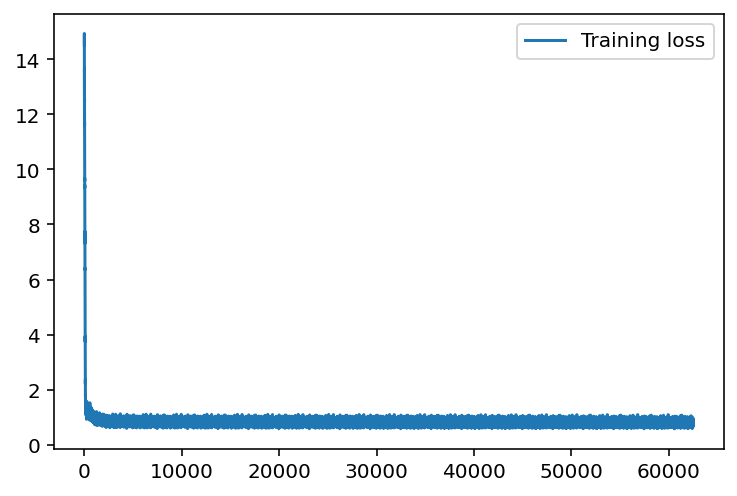

In [25]:
plt.plot(first_net.losses['train'], label='Training loss')
plt.legend()
_ = plt.ylim()

### 6.5 test loss

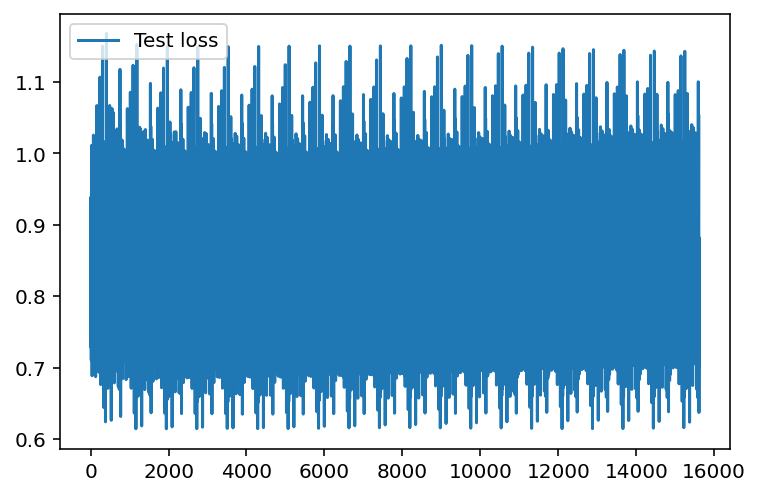

In [26]:
plt.plot(first_net.losses['test'], label='Test loss')
plt.legend()
_ = plt.ylim()

### 6.6Calculating user ratings for movie predictions

In [27]:
def rat_the_film(first_net, user_id_val, movie_id_val):
    categories = np.zeros([1, 18])
    categories[0] = movies.values[movieid2idx[movie_id_val]][2]
    
    titles = np.zeros([1, sentences_size])
    titles[0] = movies.values[movieid2idx[movie_id_val]][1]
    
    inference_val = first_net.model([np.reshape(users.values[user_id_val-1][0], [1, 1]),
              np.reshape(users.values[user_id_val-1][1], [1, 1]),
              np.reshape(users.values[user_id_val-1][2], [1, 1]),
              np.reshape(users.values[user_id_val-1][3], [1, 1]),
              np.reshape(movies.values[movieid2idx[movie_id_val]][0], [1, 1]),
              categories,  
              titles])

    return (inference_val.numpy())

### 7.predict the rating of movie

### 7.1 We start by randomly selecting 10 different people to rate the same movie film, then ten different scores will be generated

In [28]:
rat_the_film(first_net, 300, 1300)

array([[4.491043]], dtype=float32)

In [29]:
rat_the_film(first_net, 209, 1300)

array([[3.8555791]], dtype=float32)

In [30]:
rat_the_film(first_net, 208, 1300)

array([[3.9885392]], dtype=float32)

In [31]:
rat_the_film(first_net, 207, 1300)

array([[4.025576]], dtype=float32)

In [32]:
rat_the_film(first_net, 1, 1300)

array([[4.3729134]], dtype=float32)

In [33]:
rat_the_film(first_net, 21, 1300)

array([[3.6308107]], dtype=float32)

In [34]:
rat_the_film(first_net, 568, 1300)

array([[4.4454937]], dtype=float32)

In [35]:
rat_the_film(first_net, 1001, 1300)

array([[4.242361]], dtype=float32)

In [36]:
rat_the_film(first_net, 3000, 1300)

array([[3.789609]], dtype=float32)